# 🟢 Phase 1: Data Curation

**Goal:** Download raw Amazon review data, filter it for items with prices, and format it for our AI models.

**Output:** A clean dataset saved to Hugging Face.

In [1]:

!pip install -q transformers datasets tqdm



In [2]:
from huggingface_hub import login
from google.colab import userdata

# If using Colab Secrets, add your token with name 'HF_TOKEN'
try:
    login(userdata.get('HF_TOKEN'))
except:
    login()  # Manual login


In [3]:
from typing import Optional
import re
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from transformers import AutoTokenizer
from datasets import load_dataset


In [4]:
# Model + token limits
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"

MIN_TOKENS = 150
MAX_TOKENS = 160

MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

# Dataset filters
CHUNK_SIZE = 1000
MIN_PRICE = 0.5
MAX_PRICE = 999.49


In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)


In [6]:
class Item:
    """
    A cleaned, curated datapoint of a product with a price
    """

    PREFIX = "Price is $"
    QUESTION = "How much does this cost to the nearest dollar?"

    REMOVALS = [
        '"Batteries Included?": "No"',
        '"Batteries Included?": "Yes"',
        '"Batteries Required?": "No"',
        '"Batteries Required?": "Yes"',
        "By Manufacturer",
        "Item",
        "Date First",
        "Package",
        ":",
        "Number of",
        "Best Sellers",
        "Number",
        "Product "
    ]

    def __init__(self, data, price):
        self.title = data.get("title", "")
        self.price = price
        self.category = None

        self.details = None
        self.prompt = None
        self.token_count = 0
        self.include = False

        self.parse(data)

    def scrub_details(self):
        details = self.details
        for remove in self.REMOVALS:
            details = details.replace(remove, "")
        return details

    def scrub(self, text):
        text = re.sub(r'[:\[\]"{}【】\s]+', ' ', text).strip()
        text = text.replace(" ,", ",").replace(",,,", ",").replace(",,", ",")
        words = text.split()
        words = [
            w for w in words
            if len(w) < 7 or not any(c.isdigit() for c in w)
        ]
        return " ".join(words)

    def parse(self, data):
        contents = ""

        description = data.get("description")
        if isinstance(description, list) and description:
            contents += "\n".join(description) + "\n"

        features = data.get("features")
        if isinstance(features, list) and features:
            contents += "\n".join(features) + "\n"

        details = data.get("details")
        if isinstance(details, str) and details:
            self.details = details
            contents += self.scrub_details() + "\n"

        if len(contents) < MIN_CHARS:
            return

        contents = contents[:CEILING_CHARS]
        text = f"{self.scrub(self.title)}\n{self.scrub(contents)}"

        tokens = tokenizer.encode(text, add_special_tokens=False)
        if len(tokens) < MIN_TOKENS:
            return

        tokens = tokens[:MAX_TOKENS]
        text = tokenizer.decode(tokens)

        self.make_prompt(text)
        self.include = True

    def make_prompt(self, text):
        self.prompt = f"{self.QUESTION}\n\n{text}\n\n"
        self.prompt += f"{self.PREFIX}{round(self.price)}.00"
        self.token_count = len(
            tokenizer.encode(self.prompt, add_special_tokens=False)
        )

    def test_prompt(self):
        return self.prompt.split(self.PREFIX)[0] + self.PREFIX

    def __repr__(self):
        return f"<{self.title} = ${self.price}>"


In [9]:
from datetime import datetime
from datasets import load_dataset

class ItemLoader:

    def __init__(self, name):
        self.name = name

    def from_datapoint(self, datapoint):
        try:
            price_str = datapoint.get("price")
            if not price_str:
                return None

            price = float(price_str)
            if MIN_PRICE <= price <= MAX_PRICE:
                item = Item(datapoint, price)
                return item if item.include else None
        except Exception:
            return None

    def load(self,per_category_target=3_000, max_rows=300_000):
        """
        per_category_target: number of items to collect for this category
        max_rows: safety cap to avoid infinite scans
        """
        start = datetime.now()
        print(f"Loading dataset: {self.name}")
        print(f"Target items for {self.name}: {per_category_target:,}")

        parquet_url = (
            "https://huggingface.co/datasets/"
            "McAuley-Lab/Amazon-Reviews-2023/resolve/main/"
            f"raw_meta_{self.name}/*.parquet"
        )

        dataset = load_dataset(
            "parquet",
            data_files=parquet_url,
            split="train",
            streaming=True
        )

        results = []
        scanned = 0

        for datapoint in dataset:
            scanned += 1

            item = self.from_datapoint(datapoint)
            if item:
                item.category = self.name
                results.append(item)

            # progress log
            if scanned % 10_000 == 0:
                print(
                    f"  scanned {scanned:,} | kept {len(results):,}"
                )

            # early stop for this category
            if len(results) >= per_category_target:
                print(f"🎯 Reached {per_category_target:,} items for {self.name}")
                break

            # safety stop
            if scanned >= max_rows:
                print(f"⚠️ Max rows reached for {self.name}")
                break

        duration = (datetime.now() - start).total_seconds() / 60
        print(
            f"Done: {len(results):,} items "
            f"in {duration:.1f} mins for {self.name}"
        )

        return results



In [10]:
import os
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from datasets import Dataset, DatasetDict
from huggingface_hub import login


In [11]:
!pip install datasets==2.19.2

In [12]:

from google.colab import userdata

hf_token = userdata.get("HF_TOKEN")
login(hf_token, add_to_git_credential=True)



In [13]:
dataset_names = [
    # "Automotive",
    "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    # "Appliances",
    "Musical_Instruments",
]


In [30]:
items = []

for dataset_name in dataset_names:
    print(f"\nProcessing category: {dataset_name}")
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

print(f"\nA grand total of {len(items):,} items")




Processing category: Automotive
Loading dataset: Automotive
Target items for Automotive: 3,000
Done: 0 items in 0.0 mins for Automotive

Processing category: Electronics
Loading dataset: Electronics
Target items for Electronics: 3,000
🎯 Reached 3,000 items for Electronics
Done: 3,000 items in 0.3 mins for Electronics

Processing category: Office_Products
Loading dataset: Office_Products
Target items for Office_Products: 3,000
Done: 0 items in 0.0 mins for Office_Products

Processing category: Tools_and_Home_Improvement
Loading dataset: Tools_and_Home_Improvement
Target items for Tools_and_Home_Improvement: 3,000
Done: 0 items in 0.0 mins for Tools_and_Home_Improvement

Processing category: Cell_Phones_and_Accessories
Loading dataset: Cell_Phones_and_Accessories
Target items for Cell_Phones_and_Accessories: 3,000
🎯 Reached 3,000 items for Cell_Phones_and_Accessories
Done: 3,000 items in 0.4 mins for Cell_Phones_and_Accessories

Processing category: Appliances
Loading dataset: Appliance

In [31]:

# Investigate the first item from the list

datapoint = items[0]

# Access various attributes
title = datapoint.title
details = datapoint.details
price = datapoint.price
category = datapoint.category

print(f"Datapoint: {datapoint}")
print(f"Title: {title}")
print(f"Detail: {details}")
print(f"Price: ${price}")
print(f"Category: {category}")

Datapoint: <Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap [Fresh Marble] = $19.99>
Title: Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap [Fresh Marble]
Detail: {"Brand": "Digi-Tatoo", "Color": "Fresh Marble", "Room Type": "Bedroom", "Material": "Vinyl", "Theme": "Marble", "Style": "fresh marble", "Age Range (Description)": "Adult", "Reusability": "Single Use", "Pattern": "Marble", "Shape": "Rectangular", "Unit Count": "1.0 Count", "Finish Type": "Powder Coated", "Item Weight": "3.84 ounces", "Package Dimensions": "14.13 x 9.8 x 0.16 inches", "Manufacturer": "Digi-Tatoo", "Country of Origin": "China", "Date First Available": "June 3, 2019", "Best Sellers Rank": {"Computers & Accessories": 87106, "Laptop Decal

In [32]:

# The prompt that will be used during training
print(items[0].prompt)
# The prompt that will be used during testing
print(items[0].test_prompt())

How much does this cost to the nearest dollar?

Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap Fresh Marble
WARNING Please IDENTIFY MODEL NUMBER on the bottom of your Macbook. Only fits for model A2338/ A2289/ A2251 (Macbook Pro 13 w/ Touch Bar, release). Extra Care Yet Not Bulky. Our skin is capable of protecting the surface of your Macbook from daily scratches, dust, oil, water and fingerprint. Your Macbook remains fresh some years later. Elegant Style. Our stylish design and printing tech give your Macbook a 360 degree decorative and impressive looking.

Price is $20.00
How much does this cost to the nearest dollar?

Digi-Tatoo Decal Skin Compatible With MacBook Pro 13 inch (Model A2338/ A2289/ A2251) - Protective and Decorative Full Body Laptop Skin Decal Sticker, Anti-Scratch Vinly Skin Sticker Wrap Fresh Marble
WARNING Please IDENTIFY MODEL 

In [33]:
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

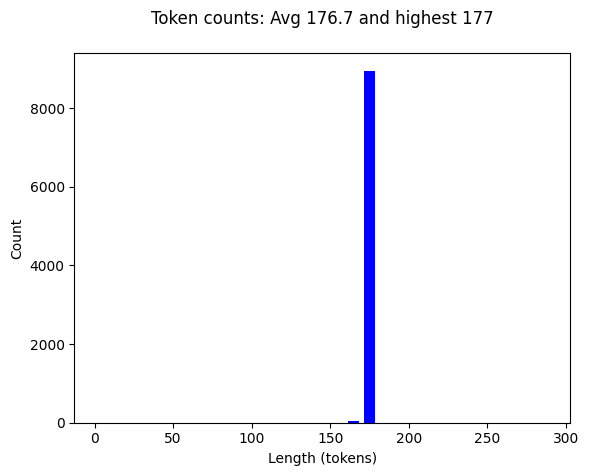

In [34]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
avg_tokens = f"{sum(tokens) / len(tokens):,.1f}"
plt.title(f"Token counts: Avg {avg_tokens} and highest {max(tokens):,}\n")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.hist(tokens, rwidth=0.7, color="blue", bins=range(0, 300, 10))
plt.show()

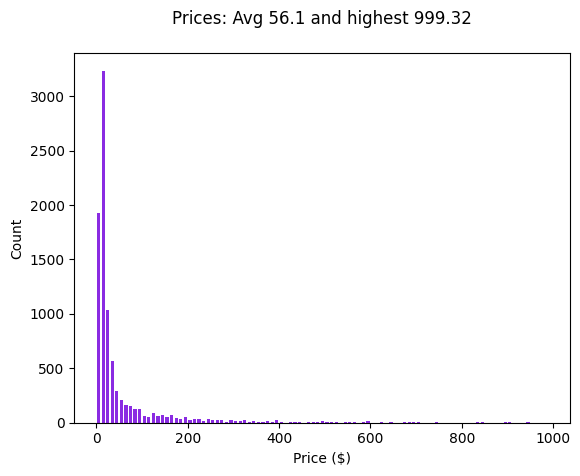

In [35]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.title(f"Prices: Avg {sum(prices) / len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()


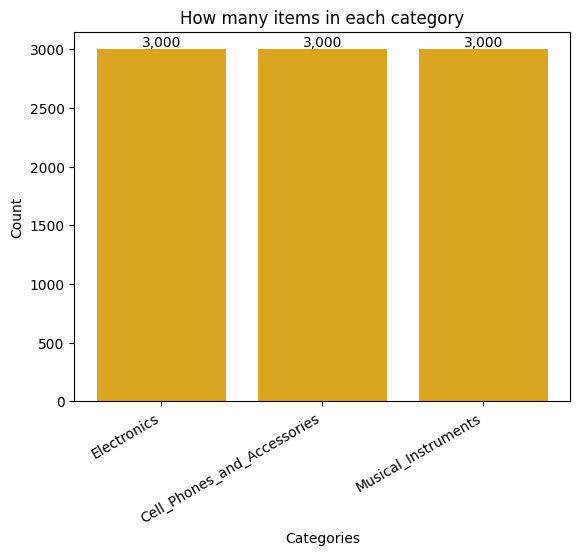

In [36]:
# Plot the distribution of categories

category_counts = Counter()
for item in items:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.bar(categories, counts, color="goldenrod")
plt.title("How many items in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()

In [37]:

HEAVY_DATASET = "Automative"

# Group items by rounded price
# Slots is a dictionary where the keys are rounded prices
# and the values are lists of items that have that rounded price
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

np.random.seed(42)  # Set random seed for reproducibility
sample = []  # Final collection of items after our sampling process completes

# Sampling loop
for price, items_at_price in slots.items():
    # Take all items if price ≥ 240 or small group
    if price >= 240 or len(items_at_price) <= 1200:
        sample.extend(items_at_price)

    # Otherwise sample 1200 items with weights
    else:
        # Weight: 1 for toys, 5 for others
        weights = [
            1 if item.category == HEAVY_DATASET else 5 for item in items_at_price
        ]
        weights = np.array(weights) / sum(weights)

        indices = np.random.choice(
            len(items_at_price),
            1200,
            replace=False,  # don't pick the same index twice
            p=weights,
        )
        sample.extend([items_at_price[i] for i in indices])

print(f"There are {len(sample):,} items in the sample")

There are 9,000 items in the sample


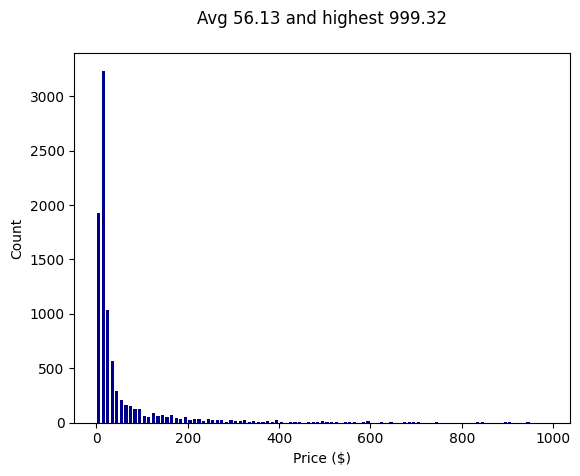

In [38]:
# Plot the distribution of prices in the sample

prices = [float(item.price) for item in sample]
plt.title(f"Avg {sum(prices) / len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()


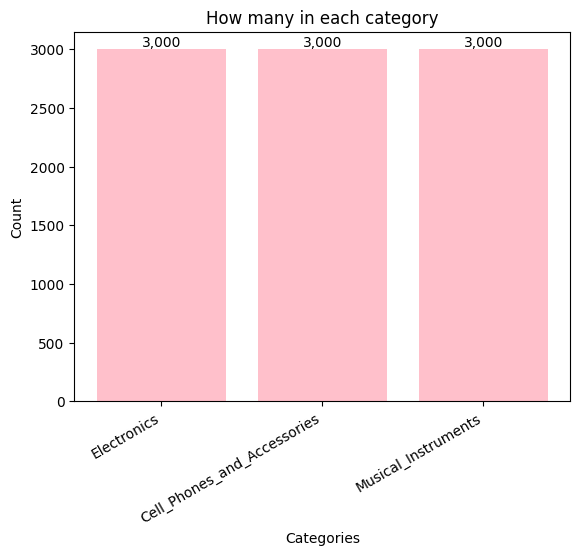

In [39]:
# Plot the distribution of categories in the sample

category_counts = Counter()
for item in sample:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.bar(categories, counts, color="pink")

# Customize the chart
plt.title("How many in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()


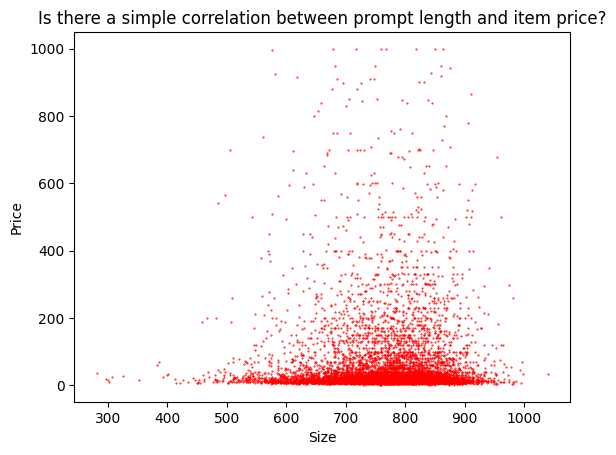

In [42]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel("Size")
plt.ylabel("Price")
plt.title("Is there a simple correlation between prompt length and item price?")

# Display the plot
plt.show()

In [45]:
def report(item):
    prompt = item.prompt
    tokens = tokenizer.encode(prompt)

    print(prompt)
    print(tokens[-10:])
    print(tokenizer.batch_decode(tokens[-10:]))



In [46]:
report(sample[50])

How much does this cost to the nearest dollar?

Patriot LX Series 64GB High Speed Micro SDXC Class 10 UHS-I Transfer Speeds For Action Cameras, Phones, Tablets, and PCs
Patriot’s LX Series UHS-I compatible MicroSDXC flash memory cards offer blazingly fast performance for the ultimate storage upgrade for HD camcorders and mid-range cameras. These memory cards are Class 10 certified and meet the latest SD Association specifications by providing a minimum sustained write speed of the bottleneck of slow memory and capture every image or video without missing a moment. With Class 10 specification, the Patriot LX Series MicroSDXC cards are fast enough to record video in full high definition. These MicroSDXC cards offer a maximum capacity of 64GBs, providing enough room to shoot and store hours of videos and thousands

Price is $20.00
[6946, 323, 9214, 271, 7117, 374, 400, 508, 13, 410]
[' videos and thousands\n\nPrice is $20.00']
